# Stock NeurIPS2018 Part 3. Backtest
This series is a reproduction of paper *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*. 

This is the third and last part of the NeurIPS2018 series, introducing how to use use the agents we trained to do backtest, and compare with baselines such as Mean Variance Optimization and DJIA index.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [1]:
## install required packages
#!pip install swig
#!pip install wrds
#!pip install pyportfolioopt
## install finrl library
#!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [28]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import A2C, PPO, SAC

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

%matplotlib inline
from finrl.config import INDICATORS

# Part 2. Backtesting

To backtest the agents, upload trade_data.csv in the same directory of this notebook. For Colab users, just upload trade_data.csv to the default directory.

In [3]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

Then, upload the trained agent to the same directory, and set the corresponding variable to True.

In [4]:
if_using_a2c = True
if_using_ppo = True
if_using_sac = True

Load the agents

In [5]:
trained_a2c = A2C.load("trained_models/agent_a2c") if if_using_a2c else None
trained_ppo = PPO.load("trained_models/agent_ppo") if if_using_ppo else None
trained_sac = SAC.load("trained_models/agent_sac") if if_using_sac else None

In [6]:
# Export trained model parameters
# model.policy.state_dict()
# model.get_parameters()

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [7]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [8]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [9]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [10]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

hit end!


In [11]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)

hit end!


In [12]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

hit end!


# Part 3: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [13]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()
  
  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [14]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate the weights for mean-variance

In [15]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[ 89.37094879, 232.42138672,  90.74230194, ...,  46.98942947,
         35.74636078, 114.19387054],
       [ 89.37094879, 235.26379395,  91.01243591, ...,  47.09257507,
         36.70822525, 113.73590088],
       [ 91.76163483, 233.4508667 ,  93.18332672, ...,  47.47935867,
         37.74003601, 113.43058014],
       ...,
       [147.13844299, 196.00279236, 178.69204712, ...,  48.2805481 ,
         45.29573822, 145.98999023],
       [147.81158447, 196.99398804, 177.35902405, ...,  48.73966217,
         44.45829773, 144.7155304 ],
       [147.34631348, 195.01159668, 174.49697876, ...,  48.32645798,
         43.36317062, 143.52861023]])

In [16]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.136 0.068 0.086 0.083 0.066 0.134 0.06  0.035 0.072 0.056 0.103 0.073
 0.033 0.076 0.047 0.073 0.042 0.056 0.054 0.056 0.103 0.089 0.041 0.053
 0.104 0.11  0.044 0.042 0.042]
Variance-Covariance matrix of returns
 [[3.156 1.066 1.768 1.669 1.722 1.814 1.569 1.302 1.302 1.811 1.303 1.432
  1.218 1.674 0.74  1.839 0.719 0.884 1.241 0.823 1.561 1.324 0.752 1.027
  1.298 1.466 0.657 1.078 0.631]
 [1.066 2.571 1.306 1.123 1.193 1.319 1.116 1.053 1.045 1.269 1.068 1.089
  0.899 1.218 0.926 1.391 0.682 0.727 1.025 1.156 1.166 0.984 0.798 0.956
  1.259 1.111 0.688 1.091 0.682]
 [1.768 1.306 4.847 2.73  2.6   2.128 1.944 2.141 2.17  3.142 1.932 2.283
  1.56  2.012 0.993 3.707 1.094 1.319 1.845 1.236 1.899 1.894 1.041 1.921
  1.823 2.314 0.986 1.421 0.707]
 [1.669 1.123 2.73  4.892 2.363 1.979 1.7   2.115 1.959 2.387 1.773 2.319
  1.571 1.797 0.968 2.597 1.144 1.298 1.643 1.071 1.615 1.775 0.91  1.666
  1.707 1.784 0.82  1.345 0.647]
 [1.722 1.193 2.6 

### Use PyPortfolioOpt

In [17]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([424250.,      0.,      0.,      0.,      0., 108650.,      0.,
            0.,      0.,      0., 181450.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  16960.,
            0.,      0.,      0., 133540., 135150.,      0.,      0.,
            0.])

In [18]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([4738.09 ,    0.   ,    0.   ,    0.   ,    0.   ,  579.993,
          0.   ,    0.   ,    0.   ,    0.   ,  777.315,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   85.651,    0.   ,    0.   ,    0.   ,
        470.265,  714.191,    0.   ,    0.   ,    0.   ])

In [19]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

# Part 4: DJIA index

Add DJIA index as a baseline to compare with.

In [20]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [21]:
df_dji = YahooDownloader(start_date = TRADE_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = ['dji']).fetch_data()
# df_dji

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (319, 8)


In [22]:
df_dji = df_dji[['date','close']]
fst_day = df_dji['close'][0]
dji = pd.merge(df_dji['date'], df_dji['close'].div(fst_day).mul(1000000), 
               how='outer', left_index=True, right_index=True).set_index('date')
# dji

<a id='4'></a>
# Part 5: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [23]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0]) if if_using_a2c else None
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0]) if if_using_ppo else None
df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0]) if if_using_sac else None

result = pd.DataFrame()
if if_using_a2c: result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
if if_using_ppo: result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
if if_using_sac: result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, dji, how='outer', left_index=True, right_index=True).fillna(method='bfill')

In [24]:
col_name = []
col_name.append('A2C') if if_using_a2c else None
col_name.append('PPO') if if_using_ppo else None
col_name.append('SAC') if if_using_sac else None
col_name.append('Mean Var')
col_name.append('djia') 
result.columns = col_name

In [25]:
result

,A2C,PPO,SAC,Mean Var,djia
date,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.001918e+06,1.000000e+06
2020-07-02,1.000430e+06,1.000071e+06,1.000248e+06,1.004235e+06,1.021449e+06
2020-07-06,1.007868e+06,1.000897e+06,1.006197e+06,1.023225e+06,1.021449e+06
2020-07-07,9.981004e+05,9.997652e+05,9.994592e+05,1.014021e+06,1.006031e+06
2020-07-08,1.005383e+06,1.000411e+06,1.004157e+06,1.029461e+06,1.012912e+06
...,...,...,...,...,...
2021-10-22,1.584533e+06,1.424569e+06,1.370542e+06,1.535668e+06,1.386322e+06
2021-10-25,1.584402e+06,1.438277e+06,1.369433e+06,1.542078e+06,1.388813e+06
2021-10-26,1.586185e+06,1.432413e+06,1.365777e+06,1.545514e+06,1.389427e+06


Now, everything is ready, we can plot the backtest result.

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

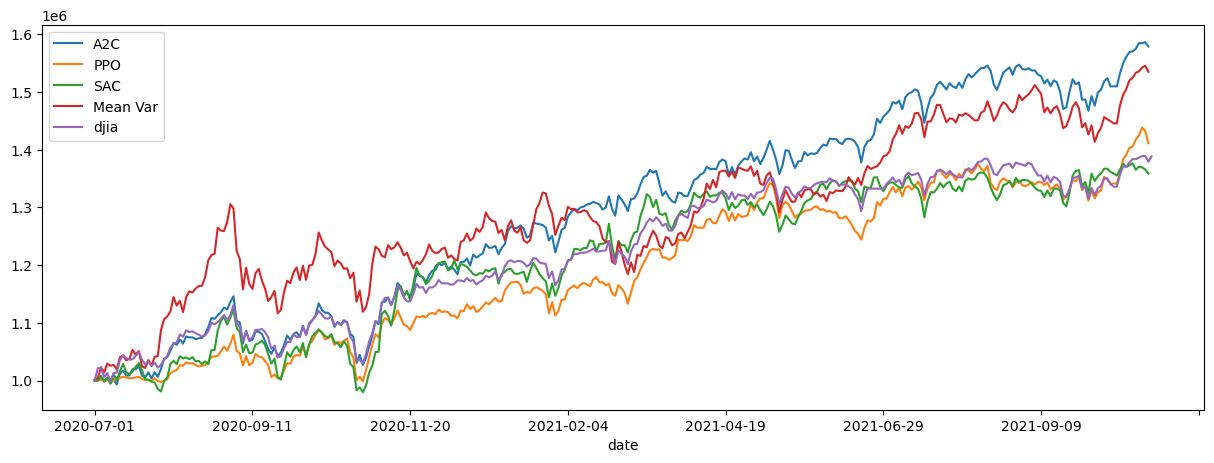

In [26]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

In [33]:
import empyrical as ep


In [38]:
result_return = result.pct_change()*100
result_return

,A2C,PPO,SAC,Mean Var,djia
date,,,,,
2020-07-01,NaN,NaN,NaN,NaN,NaN
2020-07-02,0.043027,0.007079,0.024808,0.231252,2.144939
2020-07-06,0.743486,0.082654,0.594701,1.891020,0.000000
2020-07-07,-0.969171,-0.113113,-0.669588,-0.899470,-1.509494
2020-07-08,0.729640,0.064613,0.470029,1.522592,0.684049
...,...,...,...,...,...
2021-10-22,0.636956,0.522828,0.382777,0.172544,0.207562
2021-10-25,-0.008277,0.962279,-0.080953,0.417414,0.179672
2021-10-26,0.112540,-0.407745,-0.266982,0.222830,0.044198


In [83]:
def backtest_stat(df):
    
    Cum_Return = ep.cum_returns(df/100, starting_value=0)[-1:].item()*100
    CAGR = ep.cagr(df/100, period='daily', annualization=None)*100
    Annual_Vol = ep.annual_volatility(df/100, period='daily', alpha=2.0, annualization=None, out=None)*100
    Sharpe_Ratio = ep.sharpe_ratio(df/100, risk_free=0, period='daily', annualization=None, out=None)
    Max_Drawdown = ep.max_drawdown(df/100, out=None)*100
    
    return Cum_Return, CAGR, Annual_Vol, Sharpe_Ratio, Max_Drawdown

In [115]:
backtest_result = []
for i in result_return.columns:  
    backtest_result.append(backtest_stat(result_return[i]))

pd.DataFrame(backtest_result, columns=['Cumulative Return','Annual Return','Annual Volatility','Sharpe Ratio','Max Drawdown'], index=['A2C','PPO','SAC','Mean Var','DJIA']).transpose()

,A2C,PPO,SAC,Mean Var,DJIA
Cumulative Return,57.887544,41.147166,35.875385,53.197792,38.840101
Annual Return,40.851313,29.495334,25.850687,37.701725,27.904608
Annual Volatility,16.060108,14.137512,18.411696,20.574595,13.759810
Sharpe Ratio,2.220853,1.905294,1.344625,1.663252,1.863503
Max Drawdown,-10.383590,-8.107747,-12.752304,-14.477942,-8.930776


## A2C and PPO outperforms SAC and the two baselines (Mean Var and DJIA) in terms of the risk-adjusted return measured by the Sharpe Ratio.